<a href="https://colab.research.google.com/github/adalves-ufabc/2021.QS-PLN/blob/main/2021_Q1_PLN_Notebook_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Processamento de Linguagem Natural [2020.QS]**
Prof. Alexandre Donizeti Alves

### **Modelagem de Tópicos**

Dê uma olhada no texto abaixo:

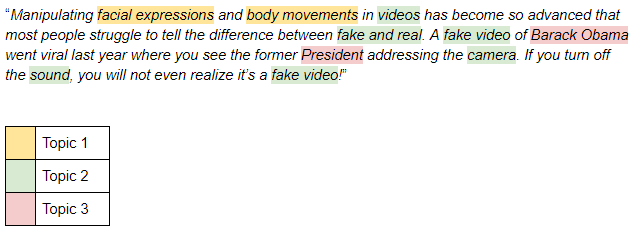

Como você pode ver no texto destacado, há três tópicos (ou conceitos) – **Tópico 1**, **Tópico 2** e **Tópico 3**. Um bom modelo de tópico identificará palavras semelhantes e as colocará em um grupo ou tópico. O tópico mais dominante no exemplo acima é o **Tópico 2**, que indica que este texto é basicamente sobre vídeos falsos.

### **Visão geral da Análise Semântica Latente** (LSA)

Todas as línguas têm suas próprias complexidades e nuances que são muito difíceis de serem capturadas por uma máquina (às vezes são até incompreendidas por nós humanos!). Isso pode incluir palavras diferentes que significam a mesma coisa, e também as palavras que têm a mesma ortografia, mas significados diferentes.

Por exemplo, considere a frase a seguir:

> Eu gostei muito do seu último romance .

>
Na frase, a palavra "romance" refere-se a um livro.

>
Podemos facilmente distinguir entre essas palavras, porque somos capazes de entender o contexto por trás dessas palavras. No entanto, uma máquina não seria capaz de capturar esse conceito, pois não pode entender o contexto em que as palavras foram usadas. É aqui que a **Análise Semântica Latente (LSA – *Latent Semantic Analysis*)** entra em ação, pois tenta alavancar o contexto em torno das palavras para capturar os conceitos ocultos, também conhecidos como `tópicos`.

Portanto, simplesmente mapear palavras para documentos não ajudará muito. O que realmente precisamos é descobrir os conceitos ocultos ou tópicos por trás das palavras. A **LSA** é uma dessas técnicas que pode encontrar esses tópicos ocultos. Vamos agora mergulhar profundamente no funcionamento interno da LSA.

### **Etapas envolvidas na implementação do LSA**

Vamos dizer que temos **m** número de documentos de texto com **n** número de termos únicos totais (palavras). Desejamos extrair **k** tópicos de todos os dados de texto nos documentos. O número de tópicos, **k**, deve ser especificado pelo usuário.

* Gere uma matriz de termo de documento de forma `m x n` com pontuações TF-IDF.

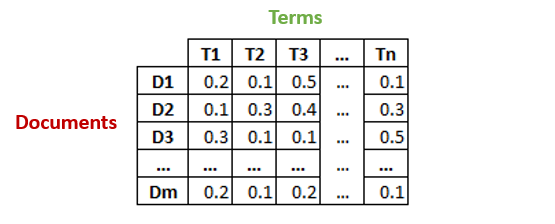

* Em seguida, reduziremos as dimensões da matriz acima para as dimensões **k** (número de tópicos desejados), usando a decomposição de valores singulares (SVD).

* SVD decompõe uma matriz em três outras matrizes. Suponha que queremos decompor uma matriz A usando SVD. Ele será decomposto em matriz U, matriz S e $V^T$ (transposição da matriz V).

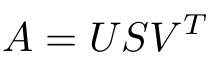

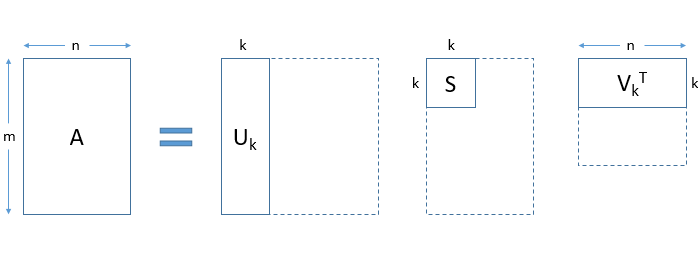

Cada linha da matriz $U_k$  (matriz termo-documento) é a representação vetorial do documento correspondente. O comprimento desses vetores é **k**, que é o número de tópicos desejados. Representação vectorial para os termos em nossos dados podem ser encontrados na matriz $V_k$ (matriz termo-tópico) .

>
* Então, o SVD nos fornece vetores para cada documento e termo em nossos dados. O comprimento de cada vetor é **k**. Podemos então usar esses vetores para encontrar palavras semelhantes e documentos semelhantes usando o método de similaridade por cosseno.

### **Implementação**

In [14]:
# carregar as bibliotecas necessárias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_colwidth", 200)

In [15]:
# https://archive.ics.uci.edu/ml/datasets/Twenty+Newsgroups

# conjunto de dados "20 Newsgroup" do sklearn
from sklearn.datasets import fetch_20newsgroups

dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data
len(documents)

11314

In [16]:
dataset.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

O conjunto de dados possui 11.314 documentos de texto distribuídos em 20 grupos de notícias distintos.

**Pré-processamento de dados**

Para começar, vamos tentar limpar nossos dados de texto o máximo possível. A ideia é remover as pontuações, números e caracteres especiais em uma única etapa, usando o `regex` `replace`, que substituirá tudo, exceto os alfabetos com espaço. 

>
Em seguida, removeremos as palavras mais curtas porque elas geralmente não contêm informações úteis. Por fim, faremos todo o texto em minúsculas para anular a diferenciação entre maiúsculas e minúsculas.

In [17]:
# pre-processamento

news_df = pd.DataFrame({'document':documents})

# removing everything except alphabets`
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z#]", " ")

# removing short words
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# make all text lowercase
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

In [18]:
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

# tokenization
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split()) 

# remove stop-words
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

# de-tokenization
detokenized_doc = []
for i in range(len(news_df)):
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)
    
news_df['clean_doc'] = detokenized_doc

Este é o primeiro passo para a modelagem de tópicos. Usaremos o `TfidfVectorizer` da `sklearn` para criar uma matriz termo-documento com 1.000 termos.

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', 
                             max_features= 1000, # keep top 1000 terms 
                             max_df = 0.5, 
                             smooth_idf=True)

X = vectorizer.fit_transform(news_df['clean_doc'])

X.shape # check shape of the document-term matrix

(11314, 1000)

Poderíamos ter usado todos os termos para criar essa matriz, mas isso exigiria bastante tempo e recursos de computação. Por isso, restringimos o número de recursos a 1.000. Se você tiver o poder computacional, sugiro experimentar todos os termos.

**Modelagem de Tópicos**

O próximo passo é representar cada termo e documento como um vetor. Usaremos a matriz termo-documento e a decomporemos em várias matrizes. Usaremos o `TruncatedSVD` do `sklearn` para executar a tarefa de decomposição da matriz.

>
Como os dados vêm de 20 grupos de notícias diferentes, vamos tentar ter 20 tópicos para nossos dados de texto. O número de tópicos pode ser especificado usando o parâmetro `n_components`.

In [21]:
from sklearn.decomposition import TruncatedSVD

# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=20, algorithm='randomized', n_iter=100, random_state=122)

svd_model.fit(X)

len(svd_model.components_)

20

Os componentes do `svd_model` são os nossos tópicos, e podemos acessá-los usando `svd_model.components_`. Finalmente, vamos imprimir algumas das palavras mais importantes em cada um dos 20 tópicos e ver como nosso modelo foi feito.

In [22]:
terms = vectorizer.get_feature_names()

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0])
    print(" ")

Topic 0: 
like
know
people
think
good
time
thanks
 
Topic 1: 
thanks
windows
card
drive
mail
file
advance
 
Topic 2: 
game
team
year
games
season
players
good
 
Topic 3: 
drive
scsi
disk
hard
card
drives
problem
 
Topic 4: 
windows
file
window
files
program
using
problem
 
Topic 5: 
government
chip
mail
space
information
encryption
data
 
Topic 6: 
like
bike
know
chip
sounds
looks
look
 
Topic 7: 
card
sale
video
offer
monitor
price
jesus
 
Topic 8: 
know
card
chip
video
government
people
clipper
 
Topic 9: 
good
know
time
bike
jesus
problem
work
 
Topic 10: 
think
chip
good
thanks
clipper
need
encryption
 
Topic 11: 
thanks
right
problem
good
bike
time
window
 
Topic 12: 
good
people
windows
know
file
sale
files
 
Topic 13: 
space
think
know
nasa
problem
year
israel
 
Topic 14: 
space
good
card
people
time
nasa
thanks
 
Topic 15: 
people
problem
window
time
game
want
bike
 
Topic 16: 
time
bike
right
windows
file
need
really
 
Topic 17: 
time
problem
file
think
israel
long
mail
 
Topi

**Visualização de Tópicos**

Para descobrir como nossos tópicos são distintos, devemos visualizá-los. Aqui vamos usar uma técnica relativamente nova chamada UMAP (*Uniform Manifold Approximation and Projection*).

In [23]:
#!pip uninstall umap
!pip install umap-learn

import umap.umap_ as umap

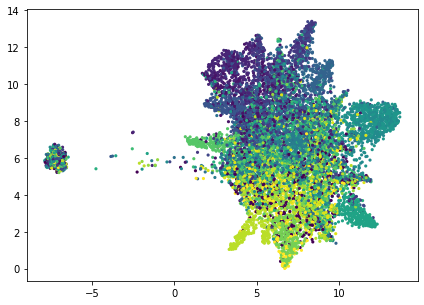

In [13]:
import umap

X_topics = svd_model.fit_transform(X)
embedding = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=12).fit_transform(X_topics)

plt.figure(figsize=(7,5))
plt.scatter(embedding[:, 0], embedding[:, 1],  
            c = dataset.target,
            s = 10, # size
            edgecolor='none'
            )
plt.show()

Como você pode ver acima, o resultado é muito bonito. Cada ponto representa um documento e as cores representam os 20 grupos de notícias. Nosso modelo LSA parece ter feito um bom trabalho. Sinta-se à vontade para brincar com os parâmetros do UMAP para ver como o enredo muda sua forma.

**Prós e Contras da LSA**

A análise semântica latente pode ser muito útil, como vimos acima, mas tem suas limitações. É importante entender os dois lados da LSA para que você tenha uma ideia de quando aproveitá-la e quando tentar outra coisa.

>
**Prós**:

*    A LSA é rápida e fácil de implementar.
*    Dá resultados decentes, muito melhor do que um modelo simples de espaço vetorial.

>
**Contras**:

*    Como é um modelo linear, pode não funcionar bem em conjuntos de dados com dependências não lineares.
*    LSA assume uma distribuição Gaussiana dos termos nos documentos, o que pode não ser verdade para todos os problemas.
* O LSA envolve o SVD, que é computacionalmente intensivo e difícil de atualizar à medida que surgem novos dados.


**Mais informações:**

> https://www.analyticsvidhya.com/blog/2018/10/stepwise-guide-topic-modeling-latent-semantic-analysis/

>> https://blogdozouza.wordpress.com/2019/04/01/uma-introducao-a-modelagem-de-topicos-utilizando-analise-semantica-latente-em-python/